### FILE PATH FIX IN KERNEL

In [21]:
import os

# Get the current directory (which is likely wrong)
current_dir = os.getcwd()

# Navigate up until we find the project root ('EngineSentinel')
project_root = current_dir
while os.path.basename(project_root) != 'EngineSentinel':
    project_root = os.path.dirname(project_root)
    # Safety break to prevent infinite loop
    if project_root == os.path.dirname(project_root):
        print("Error: Could not find project root 'EngineSentinel'. Please check folder name.")
        break

# Change the current working directory to the project root
os.chdir(project_root)

print(f"Directory Fix Complete. New Current Working Directory: {os.getcwd()}")

Directory Fix Complete. New Current Working Directory: /Users/dhruv/Desktop/EngineSentinel


Engine Sentinel - Exploratory Data Analysis


### 1. Import Libraries

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style for better aesthetics
sns.set_style('whitegrid')

### 2. Load the Training Data

We will now load the `train_FD001.txt` file. Based on the dataset's documentation, we need to manually assign column names.

In [23]:
# Now that our directory is fixed, we can use a simple relative path.
file_path = 'data/train_FD001.txt'

# Define column names based on the dataset documentation
column_names = ['unit_number', 'time_in_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + \
               [f'sensor_{i}' for i in range(1, 22)]

# Load the data
train_df = pd.read_csv(file_path, sep=' ', header=None)

# Drop the extra empty columns
train_df.drop(columns=[26, 27], inplace=True)

# Assign the correct column names
train_df.columns = column_names

print(f"Successfully loaded data from: {file_path}")

Successfully loaded data from: data/train_FD001.txt


### 3. Initial Data Inspection

Now that the data is loaded, let's look at the first few rows to ensure the columns were named correctly.

In [24]:
train_df.head(195)

,unit_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,1,191,-0.0000,-0.0004,100.0,518.67,643.34,1602.36,1425.77,14.62,...,519.57,2388.30,8114.61,8.5174,0.03,394,2388,100.0,38.45,23.1295
191,1,192,0.0009,-0.0000,100.0,518.67,643.54,1601.41,1427.20,14.62,...,520.08,2388.32,8110.93,8.5113,0.03,396,2388,100.0,38.48,22.9649
192,2,1,-0.0018,0.0006,100.0,518.67,641.89,1583.84,1391.28,14.62,...,522.33,2388.06,8137.72,8.3905,0.03,391,2388,100.0,38.94,23.4585
193,2,2,0.0043,-0.0003,100.0,518.67,641.82,1587.05,1393.13,14.62,...,522.70,2387.98,8131.09,8.4167,0.03,392,2388,100.0,39.06,23.4085


### 4. Feature Engineering: Calculate Remaining Useful Life (RUL)

This is the most critical step. Our goal is to predict how many cycles an engine has left before it fails. To train a model to do this, we first need to calculate the actual RUL for every single row in our training data.

**The Logic:**
1.  For each engine (`unit_number`), find its very last cycle. This is its 'time of failure'.
2.  For any given row, the RUL is simply the 'time of failure' minus that row's current `time_in_cycles`.

In [25]:
# Step 1: Find the maximum (last) cycle for each engine
max_cycles_df = train_df.groupby('unit_number')['time_in_cycles'].max().reset_index()
max_cycles_df.columns = ['unit_number', 'max_cycles'] # Rename for clarity

# Step 2: Merge this 'max_cycles' information back into the original dataframe
train_df = pd.merge(train_df, max_cycles_df, on='unit_number', how='left')

# Step 3: Calculate the RUL for each row
train_df['RUL'] = train_df['max_cycles'] - train_df['time_in_cycles']

# We don't need the 'max_cycles' column anymore, so let's drop it
train_df.drop(columns=['max_cycles'], inplace=True)

print("RUL calculation complete.")

RUL calculation complete.


In [31]:
# Display the first 5 rows for engine 1 to see the new RUL column
train_df[train_df['unit_number'] == 1].head(200)

,unit_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1,188,-0.0067,0.0003,100.0,518.67,643.75,1602.38,1422.78,14.62,...,2388.23,8117.69,8.5207,0.03,396,2388,100.0,38.51,22.9588,4
188,1,189,-0.0006,0.0002,100.0,518.67,644.18,1596.17,1428.01,14.62,...,2388.33,8117.51,8.5183,0.03,395,2388,100.0,38.48,23.1127,3
189,1,190,-0.0027,0.0001,100.0,518.67,643.64,1599.22,1425.95,14.62,...,2388.35,8112.58,8.5223,0.03,398,2388,100.0,38.49,23.0675,2
190,1,191,-0.0000,-0.0004,100.0,518.67,643.34,1602.36,1425.77,14.62,...,2388.30,8114.61,8.5174,0.03,394,2388,100.0,38.45,23.1295,1


### 5. Visualize the Target Variable (RUL)

Now that we have our target variable, let's plot a histogram to see its distribution. This helps us understand the range of RUL values we will be predicting.

/Users/dhruv/Desktop/EngineSentinel/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/dhruv/Desktop/EngineSentinel/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/dhruv/Desktop/EngineSentinel/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)


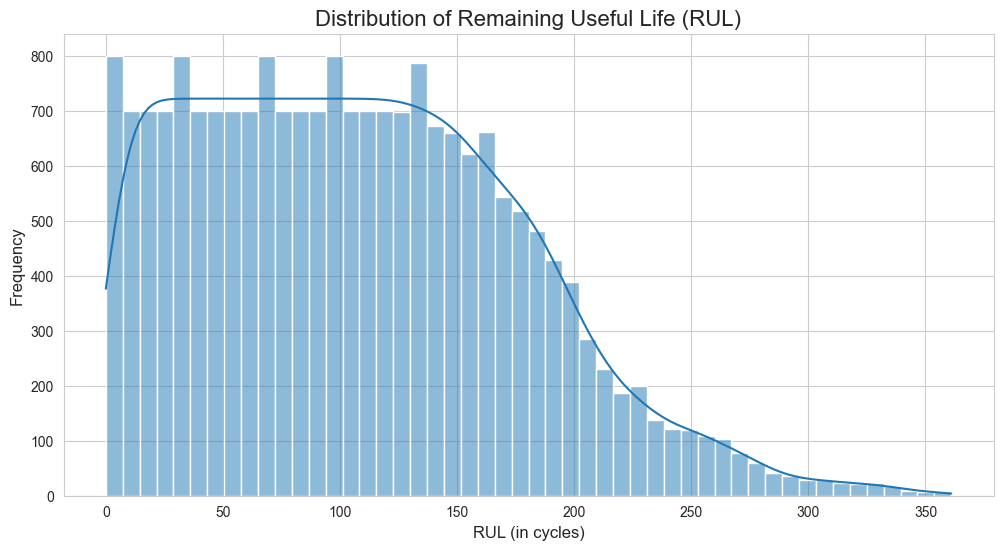

In [27]:
plt.figure(figsize=(12, 6))
sns.histplot(train_df['RUL'], bins=50, kde=True)
plt.title('Distribution of Remaining Useful Life (RUL)', fontsize=16)
plt.xlabel('RUL (in cycles)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

### 6. Data Summary and Missing Values

Let's generate a statistical summary of all our columns. This will help us understand the range of values for each sensor and, most importantly, check if we have any missing data that we need to handle.

In [28]:
# Get a statistical summary of the data
print("Data Description:")
display(train_df.describe())

# Check for any missing values
print("\nMissing Values Check:")
display(train_df.isnull().sum())

Data Description:


,unit_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,107.807862
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251,68.880990
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,0.000000
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,51.000000
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,103.000000
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,155.000000
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,361.000000



Missing Values Check:


unit_number       0
time_in_cycles    0
op_setting_1      0
op_setting_2      0
op_setting_3      0
sensor_1          0
sensor_2          0
sensor_3          0
sensor_4          0
sensor_5          0
sensor_6          0
sensor_7          0
sensor_8          0
sensor_9          0
sensor_10         0
sensor_11         0
sensor_12         0
sensor_13         0
sensor_14         0
sensor_15         0
sensor_16         0
sensor_17         0
sensor_18         0
sensor_19         0
sensor_20         0
sensor_21         0
RUL               0
dtype: int64

### 7. Save the Processed Data

We have successfully loaded the raw data, cleaned it, and engineered our target variable (RUL). Our dataset is now ready for modeling.

We will save this final, processed DataFrame to a new CSV file. This file will be the clean input for our next notebook, `02_Modeling.ipynb`.

In [29]:
import os

# Define the output path in an 'artifacts' folder to keep things organized
output_dir = 'artifacts'
output_file_path = os.path.join(output_dir, 'processed_train_data.csv')

# Create the artifacts directory if it doesn't already exist
os.makedirs(output_dir, exist_ok=True)

# Save the final dataframe to a CSV file
train_df.to_csv(output_file_path, index=False)

print(f"Processed data saved successfully to: {output_file_path}")

Processed data saved successfully to: artifacts/processed_train_data.csv
